In [1]:
%pip install skfeature-chappers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter

# Data processing libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# Feature selection and extraction
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.decomposition import PCA
from skfeature.function.information_theoretical_based import MRMR

# ML models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# For reproducibility
np.random.seed(42)

In [3]:
def generate_synthetic_data(sample_data, n_samples):
    """
    Generate synthetic data based on the sample to demonstrate the pipeline
    """
    # Create a larger synthetic dataset based on the patterns in the samples
    synth_data = pd.DataFrame(columns=sample_data.columns)
    
    # Get the numerical and categorical columns
    numerical_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
    categorical_cols = [col for col in sample_data.columns if col not in numerical_cols and col != 'income']
    
    # Calculate statistics for numerical columns
    num_stats = {col: (sample_data[col].mean(), sample_data[col].std()) for col in numerical_cols}
    
    # Get unique values for categorical columns
    cat_values = {col: sample_data[col].unique() for col in categorical_cols}
    
    # Generate synthetic samples
    synthetic_samples = []
    
    # Ensure class balance is closer to 75-25 (<=50K vs >50K)
    for i in range(n_samples):
        new_sample = {}
        
        # Generate numerical features with realistic distributions
        for col in numerical_cols:
            mean, std = num_stats[col]
            new_sample[col] = max(0, int(np.random.normal(mean, std)))
        
        # Generate categorical features based on sample distribution
        for col in categorical_cols:
            new_sample[col] = np.random.choice(cat_values[col])
        
        # Assign label class - 75% <=50K, 25% >50K for demonstration
        if i < 0.75 * n_samples:
            new_sample['label'] = '<=50K'
        else:
            new_sample['label'] = '>50K'
            
            # Higher education, age, hours worked for >50K group
            new_sample['education_num'] = max(12, new_sample['education_num'])
            new_sample['age'] = max(30, new_sample['age'])
            new_sample['hours_per_week'] = max(35, new_sample['hours_per_week'])
            
            # Higher capital gain probability
            if np.random.random() > 0.7:
                new_sample['capital-gain'] = np.random.randint(1000, 10000)
        
        synthetic_samples.append(new_sample)
    
    return pd.DataFrame(synthetic_samples)


# Load the dataset
def load_data():
    """
    Load the Adult dataset either from a URL or use a sample if URL not provided
    """
    # For this implementation, we'll use the sample data provided
    # In a real scenario, you would download from the URL
    

    # Define column names based on dataset description.
    columns = ["age", "workclass", "fnlwgt", "education", "education_num", 
               "marital_status", "occupation", "relationship", "race", "sex", 
               "capital_gain", "capital_loss", "hours_per_week", "native_country", "label"]
    
    # Load dataset (treat " ?" as NA).
    data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", 
                       header=None, names=columns, na_values=" ?")
    
    data.dropna(inplace=True)
    
    # Display the first few rows of the DataFrame
    print(data.head())
    
    # Correctly assign the column names
    data.columns = columns
    
    # Display the first few rows to verify the changes
    print(data.head())
    
    # Note: In an actual implementation, you'd use:
    # data = pd.read_csv(file_url, names=columns)
    
    # For demonstration, let's create a synthetic expanded dataset based on the sample
    # This will allow us to properly demonstrate all required techniques
    
    expanded_data = generate_synthetic_data(data, 1000)  
    
    return expanded_data

load_data()

   age          workclass  fnlwgt   education  education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital_status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital_gain  capital_loss  hours_per_week  native_country   label  
0          2174             0              40   United-States   <=50

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass,education,marital_status,occupation,relationship,race,sex,native_country,label,capital-gain
0,44,175185,11,12372,0,38,Private,Prof-school,Separated,Prof-specialty,Wife,Other,Female,France,<=50K,NaN
1,38,144596,8,221,178,31,Federal-gov,Assoc-acdm,Married-spouse-absent,Machine-op-inspct,Wife,Other,Male,Honduras,<=50K,NaN
2,34,186641,10,6014,31,40,Self-emp-not-inc,Masters,Married-spouse-absent,Protective-serv,Own-child,Other,Female,Greece,<=50K,NaN
3,22,146576,8,12381,218,24,Local-gov,12th,Married-civ-spouse,Tech-support,Own-child,Black,Female,Nicaragua,<=50K,NaN
4,26,315375,12,20763,194,60,Self-emp-not-inc,Doctorate,Married-spouse-absent,Protective-serv,Own-child,Other,Male,Japan,<=50K,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,53,276720,12,0,28,35,State-gov,Assoc-acdm,Never-married,Armed-Forces,Husband,White,Female,Holand-Netherlands,>50K,NaN
996,64,120436,12,0,0,35,Self-emp-inc,7th-8th,Widowed,Armed-Forces,Wife,Black,Male,United-States,>50K,6431.0
997,30,103233,12,7,175,56,Self-emp-not-inc,1st-4th,Never-married,Prof-specialty,Husband,Black,Male,China,>50K,4742.0
998,43,104070,12,0,0,46,Self-emp-not-inc,9th,Separated,Protective-serv,Husband,Black,Female,India,>50K,NaN


In [4]:
# Data splitting function 
def split_data(data, test_size=0.2, val_size=0.1):
    """
    Split data into train (70%), validation (10%), and test (20%) sets
    """
    # First split: 80% train+val, 20% test
    X = data.drop('label', axis=1)
    y = data['label']
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y)
    
    # Second split: 70% train, 10% validation (87.5% of train_val is train)
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_ratio, random_state=42, stratify=y_train_val)
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    return X_train, X_val, X_test, y_train, y_val, y_test


In [5]:
# Data preprocessing function
def preprocess_data(X_train, X_val, X_test):
    """
    Preprocess the data: handle categorical features, missing values, scaling
    """
    # Identify numerical and categorical columns
    numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    
    # Create preprocessing pipelines
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    # Fit and transform the data
    X_train_processed = preprocessor.fit_transform(X_train)
    X_val_processed = preprocessor.transform(X_val)
    X_test_processed = preprocessor.transform(X_test)
    
    # Get feature names after one-hot encoding
    cat_feature_names = []
    if categorical_cols:
        encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_feature_names = encoder.get_feature_names_out(categorical_cols)
    
    feature_names = np.array(numerical_cols + list(cat_feature_names))
    
    return X_train_processed, X_val_processed, X_test_processed, feature_names, preprocessor

In [6]:
# Part 1: Feature Selection Functions
def mrmr_feature_selection(X, y, k=10):
    """
    Minimum Redundancy Maximum Relevance feature selection
    """
    try:
        # Convert to numpy arrays if not already
        X_np = X if isinstance(X, np.ndarray) else X.to_numpy()
        y_np = y if isinstance(y, np.ndarray) else y.to_numpy()
        
        # Label encode the target if it's categorical
        if y_np.dtype == object or y_np.dtype.kind in ['U', 'S']:
            le = LabelEncoder()
            y_np = le.fit_transform(y_np)
        
        # Run MRMR
        selected_features = MRMR.mrmr(X_np, y_np, n_selected_features=k)
        
        return selected_features
    except Exception as e:
        print(f"MRMR feature selection failed: {e}")
        return None

def select_k_best_features(X, y, k=10, score_func=f_classif):
    """
    Select K best features based on statistical tests
    """
    selector = SelectKBest(score_func=score_func, k=k)
    X_new = selector.fit_transform(X, y)
    
    # Get selected feature indices
    selected_indices = selector.get_support(indices=True)
    
    return selected_indices, X_new

def recursive_feature_elimination(X, y, n_features=10):
    """
    Recursive Feature Elimination using Random Forest
    """
    estimator = RandomForestClassifier(n_estimators=100, random_state=42)
    selector = RFE(estimator, n_features_to_select=n_features, step=1)
    selector = selector.fit(X, y)
    
    # Get selected feature indices
    selected_indices = np.where(selector.support_)[0]
    
    return selected_indices, selector.transform(X)

# Part 1: Feature Extraction Function
def apply_pca(X_train, X_val, X_test, n_components=None, variance_threshold=0.95):
    """
    Apply PCA for dimensionality reduction
    If n_components is None, select components to explain variance_threshold of variance
    """
    if n_components is None:
        # Start with all components
        pca_full = PCA(random_state=42)
        pca_full.fit(X_train)
        
        # Calculate cumulative explained variance
        cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
        
        # Find number of components needed to explain variance_threshold
        n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
        print(f"Selected {n_components} components to explain {variance_threshold*100:.1f}% of variance")
    
    # Apply PCA with selected number of components
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)
    
    return X_train_pca, X_val_pca, X_test_pca, pca


In [7]:
# Part 2: Data Balancing Function
def balance_dataset(X_train, y_train, method='smote'):
    """
    Balance the dataset using different techniques
    """
    print("Class distribution before balancing:")
    print(pd.Series(y_train).value_counts())
    
    if method == 'smote':
        sampler = SMOTE(random_state=42)
    elif method == 'adasyn':
        sampler = ADASYN(random_state=42)
    elif method == 'under':
        sampler = RandomUnderSampler(random_state=42)
    elif method == 'hybrid':
        # Hybrid approach: undersample majority + oversample minority
        # First undersample the majority class
        rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
        X_temp, y_temp = rus.fit_resample(X_train, y_train)
        
        # Then oversample the minority class to achieve perfect balance
        sampler = SMOTE(random_state=42)
        X_balanced, y_balanced = sampler.fit_resample(X_temp, y_temp)
        
        print("Class distribution after hybrid balancing:")
        print(pd.Series(y_balanced).value_counts())
        
        return X_balanced, y_balanced
    else:
        print("No balancing applied")
        return X_train, y_train
    
    # Apply the selected sampling method
    X_balanced, y_balanced = sampler.fit_resample(X_train, y_train)
    
    print("Class distribution after balancing:")
    print(pd.Series(y_balanced).value_counts())
    
    return X_balanced, y_balanced


In [8]:
# Part 3: Data Augmentation Function
def augment_data(X, y, noise_level=0.05, n_samples=None):
    """
    Augment data by adding Gaussian noise
    """
    if n_samples is None:
        n_samples = int(X.shape[0] * 0.3)  # Add 30% more samples by default
    
    # Create copies of existing samples with added noise
    augmented_X = []
    augmented_y = []
    
    # Get class distribution
    class_counts = Counter(y)
    minority_class = min(class_counts, key=class_counts.get)
    
    # Focus augmentation on minority class for better balance
    indices = np.where(y == minority_class)[0]
    if len(indices) == 0:  # fallback if labels are not properly encoded
        indices = np.random.choice(len(y), size=n_samples, replace=True)
    else:
        # Sample with replacement if we need more than available minority samples
        indices = np.random.choice(indices, size=n_samples, replace=len(indices) < n_samples)
    
    for idx in indices:
        # Get the original sample
        sample = X[idx].copy()
        
        # Add Gaussian noise to each feature
        noise = np.random.normal(0, noise_level, size=sample.shape)
        augmented_sample = sample + noise * np.abs(sample)  # Scale noise by feature magnitude
        
        augmented_X.append(augmented_sample)
        augmented_y.append(y[idx])
    
    # Combine original and augmented data
    X_augmented = np.vstack([X, np.array(augmented_X)])
    y_augmented = np.concatenate([y, np.array(augmented_y)])
    
    print(f"Data augmented from {X.shape[0]} to {X_augmented.shape[0]} samples")
    
    return X_augmented, y_augmented


In [9]:
# -------------------------------
# Stacking Ensemble Functions
# -------------------------------
def create_base_models():
    """
    Create a dictionary of diverse base models.
    """
    models = {
        'rf': RandomForestClassifier(n_estimators=100, random_state=42),
        'gbm': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'svm': SVC(probability=True, random_state=42),
        'lgbm': LGBMClassifier(random_state=42),
        'xgb': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'mlp': MLPClassifier(max_iter=1000, random_state=42)
    }
    return models

def build_stacking_ensemble(X_train, y_train, X_val, y_val, voting_type='soft'):
    """
    Build an ensemble using stacking or voting. (Only 'soft' and 'stacking' support predict_proba.)
    """
    base_models = create_base_models()
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    meta_learner = LogisticRegression(random_state=42)
    
    if voting_type == 'stacking':
        ensemble = StackingClassifier(
            estimators=[(name, model) for name, model in base_models.items()],
            final_estimator=meta_learner,
            cv=cv,
            stack_method='predict_proba'
        )
    else:
        ensemble = VotingClassifier(
            estimators=[(name, model) for name, model in base_models.items()],
            voting=voting_type  # Expecting 'soft' for probability estimates
        )
    ensemble.fit(X_train, y_train)
    y_val_pred = ensemble.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, pos_label='>50K' if isinstance(y_val.iloc[0], str) else 1)
    print(f"{voting_type.capitalize()} Voting Ensemble Validation F1 Score: {f1:.4f}")
    return ensemble, f1

In [10]:
# -------------------------------
# Main Pipeline Function
# -------------------------------
def run_ml_pipeline():
    """
    Run the complete ML pipeline and evaluate using AUROC.
    """
    print("Loading data...")
    data = load_data()
    
    print("\nSplitting data into train, validation, and test sets...")
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(data)
    
    print("\nPreprocessing data...")
    X_train_processed, X_val_processed, X_test_processed, feature_names, preprocessor = preprocess_data(X_train, X_val, X_test)
    
    print("\nPerforming feature selection...")
    k = min(15, X_train_processed.shape[1])
    print("Running SelectKBest...")
    selected_indices_kb, X_train_kb = select_k_best_features(X_train_processed, y_train, k=k)
    X_val_kb = X_val_processed[:, selected_indices_kb]
    X_test_kb = X_test_processed[:, selected_indices_kb]
    
    print("Running Recursive Feature Elimination...")
    selected_indices_rfe, X_train_rfe = recursive_feature_elimination(X_train_processed, y_train, n_features=k)
    X_val_rfe = X_val_processed[:, selected_indices_rfe]
    X_test_rfe = X_test_processed[:, selected_indices_rfe]
    
    try:
        print("Running MRMR...")
        selected_indices_mrmr = mrmr_feature_selection(X_train_processed, y_train, k=k)
        if selected_indices_mrmr is not None:
            X_train_mrmr = X_train_processed[:, selected_indices_mrmr]
            X_val_mrmr = X_val_processed[:, selected_indices_mrmr]
            X_test_mrmr = X_test_processed[:, selected_indices_mrmr]
        else:
            raise Exception("MRMR returned None")
    except Exception as e:
        print(f"MRMR selection failed: {e}")
        print("Defaulting to SelectKBest results")
        X_train_mrmr, X_val_mrmr, X_test_mrmr = X_train_kb, X_val_kb, X_test_kb
    
    print("\nEvaluating feature selection methods using RandomForestClassifier (AUROC)...")
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    model.fit(X_train_kb, y_train)
    kb_metric = roc_auc_score(y_val, model.predict_proba(X_val_kb)[:,1])
    print(f"SelectKBest AUROC: {kb_metric:.4f}")
    
    model.fit(X_train_rfe, y_train)
    rfe_metric = roc_auc_score(y_val, model.predict_proba(X_val_rfe)[:,1])
    print(f"RFE AUROC: {rfe_metric:.4f}")
    
    model.fit(X_train_mrmr, y_train)
    mrmr_metric = roc_auc_score(y_val, model.predict_proba(X_val_mrmr)[:,1])
    print(f"MRMR AUROC: {mrmr_metric:.4f}")
    
    best_metric = max(kb_metric, rfe_metric, mrmr_metric)
    if best_metric == kb_metric:
        print("SelectKBest performed best")
        X_train_selected, X_val_selected, X_test_selected = X_train_kb, X_val_kb, X_test_kb
        selected_indices = selected_indices_kb
    elif best_metric == rfe_metric:
        print("RFE performed best")
        X_train_selected, X_val_selected, X_test_selected = X_train_rfe, X_val_rfe, X_test_rfe
        selected_indices = selected_indices_rfe
    else:
        print("MRMR performed best")
        X_train_selected, X_val_selected, X_test_selected = X_train_mrmr, X_val_mrmr, X_test_mrmr
        selected_indices = selected_indices_mrmr
    
    if len(feature_names) > 0:
        selected_features = feature_names[selected_indices]
        print(f"Selected features: {selected_features}")
    
    baseline_model = RandomForestClassifier(n_estimators=100, random_state=42)
    baseline_model.fit(X_train_processed, y_train)
    baseline_metric = roc_auc_score(y_val, baseline_model.predict_proba(X_val_processed)[:,1])
    
    if best_metric <= baseline_metric * 1.02:
        print("\nFeature selection didn't significantly improve performance.")
        print("Applying PCA feature extraction...")
        X_train_pca, X_val_pca, X_test_pca, pca = apply_pca(X_train_processed, X_val_processed, X_test_processed)
        model.fit(X_train_pca, y_train)
        pca_metric = roc_auc_score(y_val, model.predict_proba(X_val_pca)[:,1])
        print(f"PCA AUROC: {pca_metric:.4f}")
        if pca_metric > best_metric:
            print("PCA performed better than feature selection")
            X_train_final, X_val_final, X_test_final = X_train_pca, X_val_pca, X_test_pca
        else:
            print("Feature selection performed better than PCA")
            X_train_final, X_val_final, X_test_final = X_train_selected, X_val_selected, X_test_selected
    else:
        print("Feature selection performed well, skipping PCA")
        X_train_final, X_val_final, X_test_final = X_train_selected, X_val_selected, X_test_selected
    
    print("\nChecking class balance...")
    class_counts = pd.Series(y_train).value_counts()
    if len(class_counts) > 1:
        imbalance_ratio = class_counts.max() / class_counts.min()
        if imbalance_ratio > 1.5:
            print(f"Dataset is imbalanced with ratio {imbalance_ratio:.2f}")
            print("Balancing dataset...")
            X_train_balanced, y_train_balanced = balance_dataset(X_train_final, y_train, method='hybrid')
        else:
            print(f"Dataset is relatively balanced with ratio {imbalance_ratio:.2f}")
            X_train_balanced, y_train_balanced = X_train_final, y_train
    else:
        print("Warning: Only one class detected in training data")
        X_train_balanced, y_train_balanced = X_train_final, y_train
    
    print("\nAugmenting training data...")
    X_train_augmented, y_train_augmented = augment_data(X_train_balanced, y_train_balanced)
    
    print("\nBuilding stacking ensembles (using only 'soft' and 'stacking' for probability estimates)...")
    soft_ensemble, _ = build_stacking_ensemble(X_train_augmented, y_train_augmented, X_val_final, y_val, voting_type='soft')
    stacking_ensemble, _ = build_stacking_ensemble(X_train_augmented, y_train_augmented, X_val_final, y_val, voting_type='stacking')
    
    print("\nSelecting best ensemble model based on validation AUROC...")
    soft_auroc = roc_auc_score(y_val, soft_ensemble.predict_proba(X_val_final)[:,1])
    stacking_auroc = roc_auc_score(y_val, stacking_ensemble.predict_proba(X_val_final)[:,1])
    print(f"Soft Voting AUROC: {soft_auroc:.4f}")
    print(f"Stacking Ensemble AUROC: {stacking_auroc:.4f}")
    
    if stacking_auroc >= soft_auroc:
        print("Stacking classifier performed best")
        final_ensemble = stacking_ensemble
    else:
        print("Soft voting ensemble performed best")
        final_ensemble = soft_ensemble
    
    print("\nEvaluating on test set using AUROC metric...")
    y_test_pred_proba = final_ensemble.predict_proba(X_test_final)
    test_auroc = roc_auc_score(y_test, y_test_pred_proba[:,1])
    
    # For reference, also compute F1 score (optional)
    y_test_pred = final_ensemble.predict(X_test_final)
    test_f1 = f1_score(y_test, y_test_pred, pos_label='>50K' if isinstance(y_test.iloc[0], str) else 1)
    
    print("\nFinal Test Results:")
    print(f"AUROC: {test_auroc:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # -------------------------------
    # Confusion Matrix Plot Section
    # -------------------------------
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix")
    plt.show()
    
    return {
        'model': final_ensemble,
        'preprocessor': preprocessor,
        'auroc': test_auroc,
        'f1_score': test_f1
    }


Loading data...
   age          workclass  fnlwgt   education  education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital_status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital_gain  capital_loss  hours_per_week  native_country   label  
0          2174             0              40   Unit

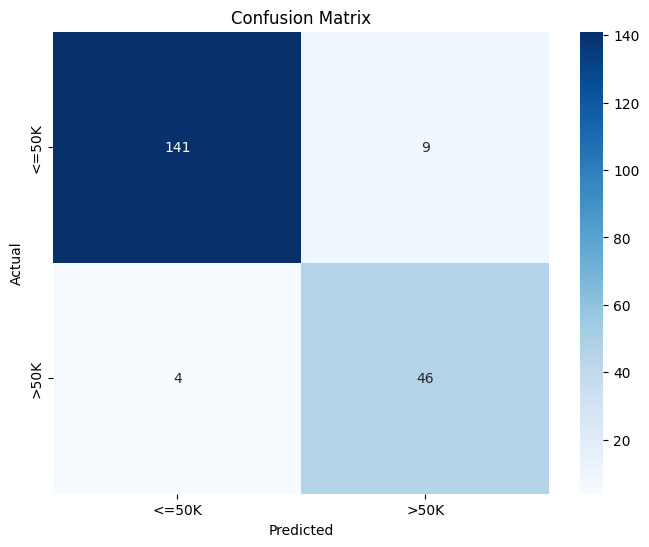


Machine Learning Pipeline Completed Successfully


In [11]:
results = run_ml_pipeline()
print("\nMachine Learning Pipeline Completed Successfully")